In [272]:
# from utils.processing import Processing
from mne.preprocessing import ICA
import matplotlib.pyplot as plt

import mne
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import wilcoxon
import random

np.random.seed(3)

In [273]:
import mne
import pathlib

data = {}
for filename in pathlib.Path("./halo-blinks/").glob("*blinks*.fif"):
    data[filename] = mne.io.read_raw(filename, preload=True, verbose=False).pick(
        ["O1", "O2", "Fp1", "Fp2"]
    )

In [274]:
segment_length = 2
raw_segments = []

for filename, raw in data.items():
    n_segments = int(np.floor(raw.times[-1] / segment_length))

    for i in range(n_segments):
        start_sec = i * segment_length
        stop_sec = start_sec + segment_length
        stop_sec = min(stop_sec, raw.times[-1])

        cropped_raw = raw.copy().crop(
            tmin=start_sec, tmax=stop_sec - 1 / raw.info["sfreq"]
        )
        raw_segments.append(cropped_raw)

In [275]:
len(raw_segments)

67

In [276]:
raw_segments[0].ch_names

['O1', 'O2', 'Fp1', 'Fp2']

In [277]:
import asrpy

In [278]:
def pipeline_ica(raw):
    raw.filter(1, 40, fir_design="firwin")
    raw.resample(256)

    reconstructed = raw.copy()

    ica = ICA(
        n_components=4,
        max_iter="auto",
        method="picard",
        random_state=97,
    ).fit(reconstructed)

    eog_indices, eog_scores = ica.find_bads_eog(
        reconstructed, ch_name=["Fp1", "Fp2"], threshold=0.7, measure="correlation"
    )
    ica.exclude = eog_indices
    ica.plot_overlay(raw, exclude=eog_indices, picks="eeg")

    ica.apply(reconstructed)

    return reconstructed

In [279]:
def pipeline_asr(raw):
    raw.filter(1, 40, fir_design="firwin")
    raw.resample(256)

    processed_raw = raw.copy()

    asr = asrpy.ASR(sfreq=256, cutoff=15)
    asr.fit(processed_raw)
    reconstructed = asr.transform(processed_raw)

    return reconstructed

In [280]:
from tensorflow.keras.models import load_model

model = load_model("./RNN_model/models/b40-LRsch.keras")

def pipeline_bilstm(raw, model):
    raw.filter(1, 40, fir_design="firwin")
    raw.resample(256)

    processed_raw = raw.copy()
    data = processed_raw.get_data()

    # Process input data
    std_devs = np.std(data, axis=1, keepdims=True)
    data_standardized = data / std_devs

    t = 2
    samples_per_segment = t * int(processed_raw.info["sfreq"])
    n_channels = data_standardized.shape[0]

    segments = []
    for channel in range(n_channels):
        channel_data = data_standardized[channel, :]
        n_segments = channel_data.shape[0] // samples_per_segment
        for segment in range(n_segments):
            start = segment * samples_per_segment
            end = start + samples_per_segment
            if end <= channel_data.shape[0]:
                segments.append(
                    channel_data[start:end].reshape(samples_per_segment, 1)
                )
    segments = np.array(segments)

    # Denoise data
    denoised_data = []
    for segment in segments:
        prediction = model.predict(
            segment[np.newaxis, :, :]
        )  # Model predicts on one segment at a time
        denoised_data.append(prediction.squeeze())
    denoised_data = np.array(denoised_data)

    # Initialize the denoised array with the correct shape
    denoised_full = np.zeros(data.shape)
    for channel in range(n_channels):
        channel_std_dev = std_devs[channel]
        n_segments = data[channel, :].shape[0] // samples_per_segment
        for segment in range(n_segments):
            start = segment * samples_per_segment
            end = start + samples_per_segment
            if end <= data[channel, :].shape[0]:
                denoised_full[channel, start:end] = (
                    denoised_data[segment * n_channels + channel] * channel_std_dev
                )

    info = mne.create_info(
        ch_names=processed_raw.info["ch_names"],
        sfreq=processed_raw.info["sfreq"],
        ch_types="eeg",
    )

    # Reconstruct signal
    reconstructed = mne.io.RawArray(denoised_full, info)

    return reconstructed

In [281]:
def rms(raw):
    """
    Computes the Root Mean Square of the signal, providing a measure of the overall power in the signal.
    """
    data = raw.get_data()
    rms = np.sqrt(np.mean(data**2))
    return np.round(rms, 4)

In [282]:
def correlation(noisy, clean):
    """
    Calculates the Pearson correlation coefficient for each channel between the
    noisy and cleaned signals to assess how well the overall structure of the signal
    is preserved post-cleaning.
    """
    correlation_coeffs = []
    for ch in range(4):
        coeff, _ = pearsonr(noisy.get_data(picks=ch)[0], clean.get_data(picks=ch)[0])
        correlation_coeffs.append(coeff)

    average_corr = np.mean(correlation_coeffs)

    return np.round(average_corr, 4)

In [283]:
def significance(noisy, clean):
    """
    Uses the Wilcoxon signed-rank test to determine if there is a
    statistically significant difference between the noisy and cleaned EEG signals.
    """
    data_original = noisy.get_data().flatten()
    data_cleaned = clean.get_data().flatten()

    _, p = wilcoxon(data_original, data_cleaned)

    return p

In [284]:
raw1 = raw_segments[34]
reconstructed = pipeline_asr(raw1)
# reconstructed = pipeline_ica(raw1)
# reconstructed = pipeline_bilstm(raw1, model)

In [285]:
rms(raw1)

26.1875

In [286]:
rms(reconstructed)

9.1479

In [287]:
correlation(raw1, reconstructed)

0.5834

In [288]:
significance(raw1, reconstructed)

0.01440385740824319

In [289]:
raw_data = raw1.get_data()
clean_data = reconstructed.get_data()
times = raw1.times

In [290]:
# plt.figure(figsize=(12, 5))

# for i in range(raw1.info["nchan"]):
#     plt.plot(times, raw_data[i], label="Triukšmingas signalas" if i == 0 else "", color="red")
#     plt.plot(
#         times, clean_data[i], label="Švarus signalas" if i == 0 else "", color="black"
#     )

# plt.xlabel("Laikas (s)")
# plt.ylabel("Amplitudė")
# plt.legend()
# plt.grid(True)
# plt.show()

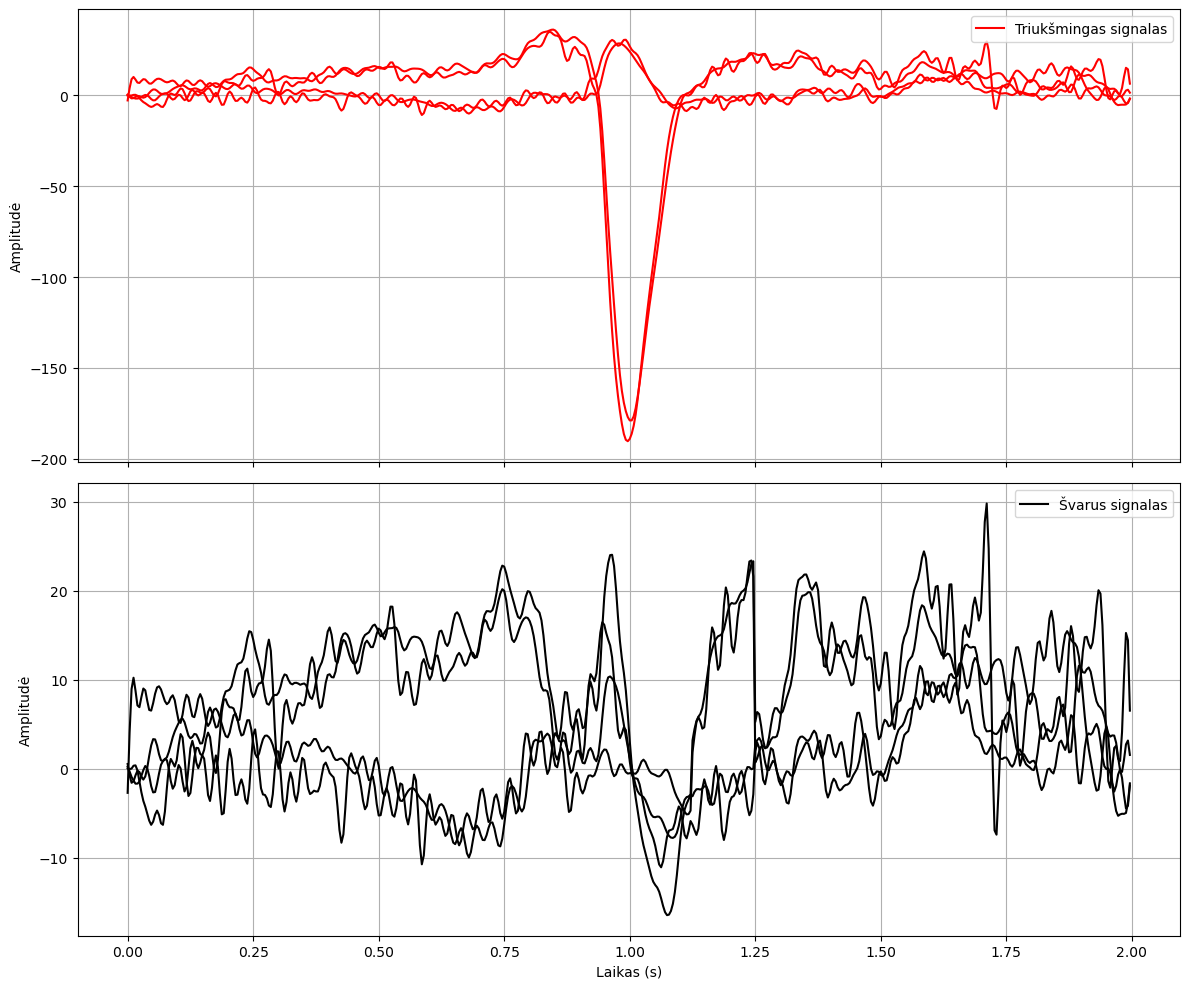

In [291]:
import matplotlib.pyplot as plt

# Assuming 'times', 'raw_data', and 'clean_data' are defined
# as your timescale and data arrays respectively

# Create a figure with two subplots (one above the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot raw data on the first subplot
for i in range(raw1.info["nchan"]):
    axes[0].plot(times, raw_data[i], color="red")
    axes[0].set_ylabel("Amplitudė")

# Plot cleaned data on the second subplot
for i in range(raw1.info["nchan"]):
    axes[1].plot(times, clean_data[i], color="black")
    axes[1].set_xlabel("Laikas (s)")
    axes[1].set_ylabel("Amplitudė")

# Add legends to each subplot
axes[0].legend(["Triukšmingas signalas"], loc="upper right")
axes[1].legend(["Švarus signalas"], loc="upper right")

# Add grid to each subplot for better readability
axes[0].grid(True)
axes[1].grid(True)

# Ensure the plot layout does not overlap and everything is clearly visible
plt.tight_layout()

# Display the plot
plt.show()